<a href="https://colab.research.google.com/github/riturajs19/Mood-melody--NLP-Project/blob/main/MoodMelodyNLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [30]:
# reading the dataset
train = pd.read_csv('train.txt', header=None, sep=';', names=['Lines','Emotions'], encoding='utf-8')
test = pd.read_csv('test.txt', header=None, sep =';', names=['Lines','Emotions'], encoding='utf-8')
validation = pd.read_csv('val.txt', header=None, sep=';', names=['Lines','Emotions'], encoding='utf-8')

In [31]:
# adding a column with encoded emotions
emotions_to_labels = {'anger': 0, 'love': 1, 'fear': 2, 'joy': 3, 'sadness': 4,'surprise': 5}
labels_to_emotions = {j:i for i,j in emotions_to_labels.items()}

train['Labels'] = train['Emotions'].replace(emotions_to_labels)
test['Labels'] = test['Emotions'].replace(emotions_to_labels)
validation['Labels'] = validation['Emotions'].replace(emotions_to_labels)

/tmp/ipython-input-2536230502.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['Labels'] = train['Emotions'].replace(emotions_to_labels)
/tmp/ipython-input-2536230502.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['Labels'] = test['Emotions'].replace(emotions_to_labels)
/tmp/ipython-input-2536230502.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future be

In [32]:
train.head()

,Lines,Emotions,Labels
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,1
4,i am feeling grouchy,anger,0


In [33]:
train.shape

(16000, 3)

In [34]:
validation.head()

,Lines,Emotions,Labels
0,im feeling quite sad and sorry for myself but ...,sadness,4
1,i feel like i am still looking at a blank canv...,sadness,4
2,i feel like a faithful servant,love,1
3,i am just feeling cranky and blue,anger,0
4,i can have for a treat or if i am feeling festive,joy,3


In [35]:
def visualize_labels_distribution(df, title='the'):
  '''
  Accepts a dataframe with 'Emotions' column and dataset title (e.g. 'train')
  Creates bar chart with num of elements of each category
  Returns nothing

  '''
  # create a pandas series with labels and their counts
  num_labels = df['Emotions'].value_counts()

  # num of unique categories
  x_barchart = range(df['Emotions'].nunique())
  # list of labels
  x_barchart_labels = [str(emotions_to_labels[emotion]) +\
                       ' - ' + emotion for emotion in list(num_labels.index)]

  # list of counts
  y_barchart = list(num_labels.values)

  # creating bar chart
  plt.figure(figsize = (5, 4))
  plt.bar(x_barchart, y_barchart, color='#707bfb')

  # adding num of elements for each category on plot as text
  for index, data in enumerate(y_barchart):
    plt.text(x = index,
            y = data+max(y_barchart)/100,
            s = '{}'.format(data),
            fontdict = dict(fontsize=10),
            ha = 'center',)

  plt.xticks(x_barchart, x_barchart_labels, rotation=40)
  plt.title('Num of elements of each category for {} dataset'.format(title))
  plt.tight_layout()

  print('There are {} records in the dataset.\n'.format(len(df.index)))

  plt.show()

There are 16000 records in the dataset.



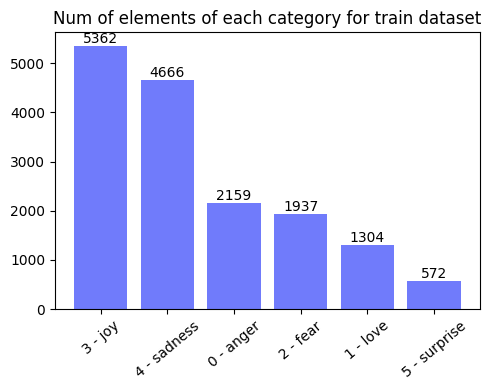

There are 2000 records in the dataset.



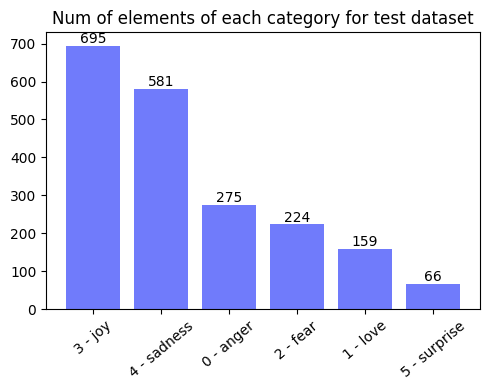

There are 2000 records in the dataset.



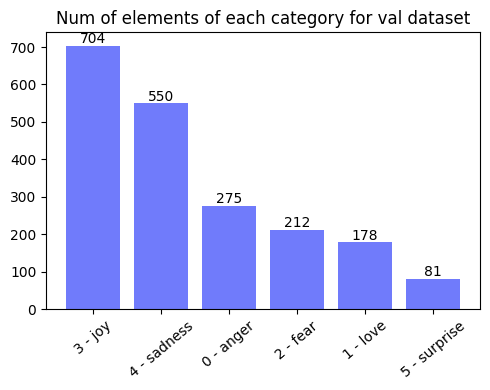

In [36]:
visualize_labels_distribution(train, 'train')
visualize_labels_distribution(test, 'test')
visualize_labels_distribution(validation, 'val')

In [37]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

# downloading a set of stop-words
STOPWORDS = set(stopwords.words('english'))

# tokenizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
def text_preprocess(text, stop_words=False):
  '''
  Accepts text (a single string) and
  a parameters of preprocessing
  Returns preprocessed text

  '''
  # clean text from non-words
  text = re.sub(r'\W+', ' ', text).lower()

  # tokenize the text
  tokens = word_tokenize(text)

  if stop_words:
    # delete stop_words
    tokens = [token for token in tokens if token not in STOPWORDS]

  return tokens

In [39]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [40]:
print('Before: ')
print(train.head())

x_train = [text_preprocess(t, stop_words=True) for t in train['Lines']]
y_train = train['Labels'].values

print('\nAfter:')
for line_and_label in list(zip(x_train[:5], y_train[:5])):
  print(line_and_label)

Before: 
                                               Lines Emotions  Labels
0                            i didnt feel humiliated  sadness       4
1  i can go from feeling so hopeless to so damned...  sadness       4
2   im grabbing a minute to post i feel greedy wrong    anger       0
3  i am ever feeling nostalgic about the fireplac...     love       1
4                               i am feeling grouchy    anger       0

After:
(['didnt', 'feel', 'humiliated'], np.int64(4))
(['go', 'feeling', 'hopeless', 'damned', 'hopeful', 'around', 'someone', 'cares', 'awake'], np.int64(4))
(['im', 'grabbing', 'minute', 'post', 'feel', 'greedy', 'wrong'], np.int64(0))
(['ever', 'feeling', 'nostalgic', 'fireplace', 'know', 'still', 'property'], np.int64(1))
(['feeling', 'grouchy'], np.int64(0))


In [41]:
x_test = [text_preprocess(t, stop_words=True) for t in test['Lines']]
y_test = test['Labels'].values

x_validation = [text_preprocess(t, stop_words=True) for t in validation['Lines']]
y_validation = validation['Labels'].values

In [17]:
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2026-02-10 08:28:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2026-02-10 08:28:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2026-02-10 08:28:59--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [18]:
!unzip glove.6B.zip


Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [19]:
glove_path = "glove.6B.100d.txt"


In [20]:
import numpy as np

def load_glove_embeddings(glove_path):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    print(f"Loaded {len(embeddings_index)} GloVe vectors")
    return embeddings_index

glove_embeddings = load_glove_embeddings("glove.6B.100d.txt")


Loaded 400000 GloVe vectors


In [21]:
print(glove_embeddings["happy"][:10])


[-0.090436  0.19636   0.29474  -0.47706  -0.80436   0.3078   -0.55205
  0.58453  -0.17056  -0.84846 ]


In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
DICT_SIZE = 15000

tokenizer = Tokenizer(num_words=DICT_SIZE)

# IMPORTANT: use tokenized text joined back into strings
tokenizer.fit_on_texts(
    [' '.join(x) for x in (x_train + x_test + x_validation)]
)



In [24]:
EMBEDDING_DIM = 100   # 300 if using glove.6B.300d.txt
DICT_SIZE = 15000

embedding_matrix = np.zeros((DICT_SIZE, EMBEDDING_DIM))
skipped_words = []

for word, index in tokenizer.word_index.items():   # ✅ lowercase tokenizer
    if index < DICT_SIZE:
        vector = glove_embeddings.get(word)
        if vector is not None:
            embedding_matrix[index] = vector
        else:
            skipped_words.append(word)

print(f"{len(skipped_words)} words not found in GloVe")
print("Some skipped words:", skipped_words[:20])


971 words not found in GloVe
Some skipped words: ['href', 'shouldnt', 'hadnt', 'youve', 'nofollow', 'werent', 'theyve', 'theyd', 'pagetitle', 'everyones', 'everythings', 'itll', 'wouldve', 'theyll', 'permalink', 'thrifted', 'hahaha', 'anyones', 'clearboth', 'couldve']


In [25]:
tokenizer.word_index["happy"]


57

In [26]:
embedding_matrix[tokenizer.word_index["happy"]][:10]


array([-0.090436  ,  0.19636001,  0.29473999, -0.47705999, -0.80435997,
        0.30779999, -0.55204999,  0.58453   , -0.17056   , -0.84846002])

In [42]:
MAX_LEN = max(
    max(len(x) for x in x_train),
    max(len(x) for x in x_test),
    max(len(x) for x in x_validation)
)

X_train = pad_sequences(tokenizer.texts_to_sequences([' '.join(x) for x in x_train]),
                         maxlen=MAX_LEN)

X_test = pad_sequences(tokenizer.texts_to_sequences([' '.join(x) for x in x_test]),
                        maxlen=MAX_LEN)

X_val = pad_sequences(tokenizer.texts_to_sequences([' '.join(x) for x in x_validation]),
                       maxlen=MAX_LEN)


In [43]:
model = Sequential()

model.add(
    Embedding(
        input_dim=DICT_SIZE,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable=False
    )
)

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(128)))
model.add(Dense(6, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,500,000 (5.72 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,500,000 (5.72 MB)

In [45]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_validation),
    batch_size=8,
    epochs=20,
    callbacks=[early_stop]
)


Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - accuracy: 0.5727 - loss: 1.1316 - val_accuracy: 0.8650 - val_loss: 0.3552
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - accuracy: 0.8924 - loss: 0.2838 - val_accuracy: 0.9225 - val_loss: 0.1786
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - accuracy: 0.9291 - loss: 0.1569 - val_accuracy: 0.9235 - val_loss: 0.1598
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - accuracy: 0.9356 - loss: 0.1262 - val_accuracy: 0.9275 - val_loss: 0.1530
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - accuracy: 0.9414 - loss: 0.1116 - val_accuracy: 0.9415 - val_loss: 0.1130
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - accuracy: 0.9469 - loss: 0.0984 - val_accuracy: 0.9385 - val_loss: 0.1288
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - accuracy: 0.9461 - loss: 0.1004 - val_accuracy: 0.9310 - val_loss: 0.1499
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - accuracy: 0.9490 -

In [49]:
def plot_history(history):
    '''
    Plots training and validation accuracy and loss
    Accepts a single param - history, where
    history - keras.callbacks.History object
    Returns nothing

    '''
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    x = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, label='Training acc', color='#707bfb')
    plt.plot(x, val_accuracy, label='Validation acc', color='#fbcbff')
    plt.title('Training and validation accuracy')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='Training loss', color='#707bfb')
    plt.plot(x, val_loss, label='Validation loss', color='#fbcbff')
    plt.title('Training and validation loss')
    plt.grid(True)
    plt.legend()

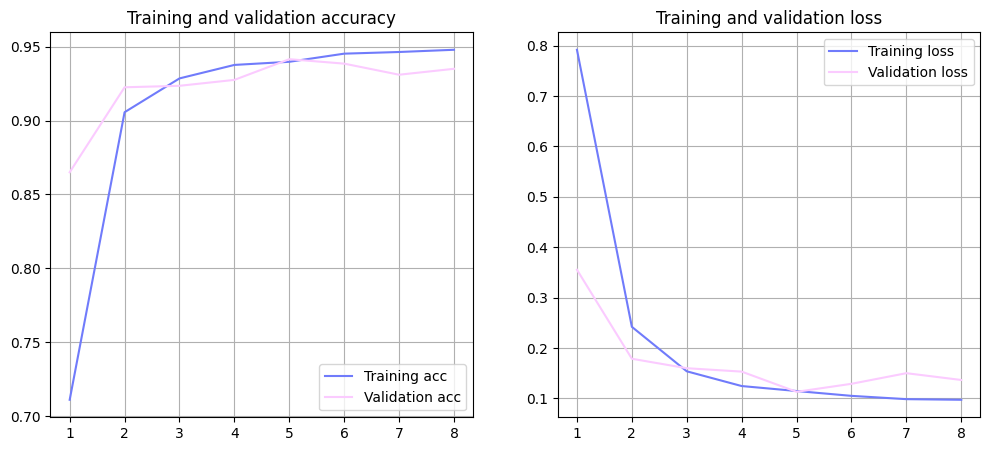

In [50]:
plot_history(history)

In [46]:
model.evaluate(X_test, y_test)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9245 - loss: 0.1281


[0.13008852303028107, 0.9269999861717224]

In [47]:
def predict_emotion(texts):
    processed = [' '.join(text_preprocess(t)) for t in texts]
    seq = tokenizer.texts_to_sequences(processed)
    pad = pad_sequences(seq, maxlen=MAX_LEN)
    preds = np.argmax(model.predict(pad), axis=1)
    for text, p in zip(texts, preds):
        print(f"'{text}' → {labels_to_emotions[p]}")


In [48]:
test_sentences = [
    "I am feeling very happy today",
    "I feel lonely and sad",
    "This situation makes me angry",
    "I am scared but hopeful"
]

predict_emotion(test_sentences)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
'I am feeling very happy today' → joy
'I feel lonely and sad' → sadness
'This situation makes me angry' → anger
'I am scared but hopeful' → fear


In [52]:
y_pred = np.argmax(model.predict(X_test), axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step


In [53]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       275
           1       0.91      0.73      0.81       159
           2       0.91      0.86      0.88       224
           3       0.93      0.97      0.95       695
           4       0.98      0.96      0.97       581
           5       0.69      0.77      0.73        66

    accuracy                           0.93      2000
   macro avg       0.89      0.88      0.88      2000
weighted avg       0.93      0.93      0.93      2000



In [54]:
# setting a custom colormap
from matplotlib.colors import LinearSegmentedColormap
colors = ['#ffffff', '#fbcbff', '#707bfb']
cmap = LinearSegmentedColormap.from_list('mycmap', colors)


In [55]:
def plot_confusion_matrix(matrix, fmt=''):
  '''
  Accepts a confusion matrix and a format param
  Plots the matrix as a heatmap
  Returns nothing

  '''
  plt.figure(figsize=(6, 5))
  sns.heatmap(matrix, annot=True,
              cmap=cmap,
              fmt=fmt,
              xticklabels=emotions_to_labels.keys(),
              yticklabels=emotions_to_labels.keys())
  plt.ylabel('True labels')
  plt.xlabel('Predicted labels')
  plt.show()

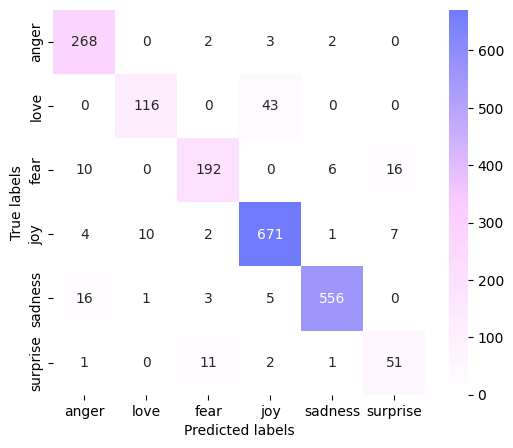

In [56]:
matrix = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(matrix)

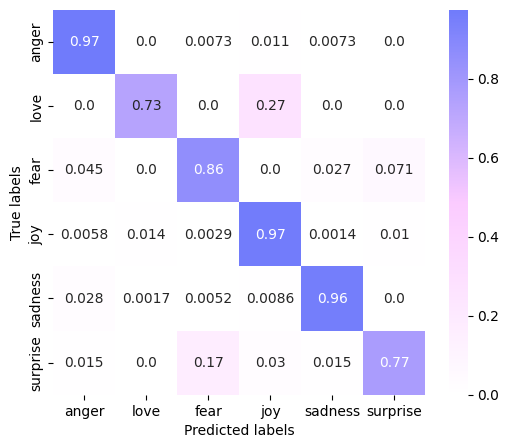

In [57]:
# create new confusion matrix
# where values are normed by row
matrix_new = np.zeros(matrix.shape)

for row in range(len(matrix)):
  sum = np.sum(matrix[row])
  for element in range(len(matrix[row])):
    matrix_new[row][element] = matrix[row][element] / sum

plot_confusion_matrix(matrix_new, fmt='.2')

In [58]:
def predict(texts):
  '''
  Accepts array if texts (strings)
  Prints sentence and the corresponding label (emotion)
  Returns nothing

  '''
  texts_prepr = [text_preprocess(t) for t in texts]
  sequences = tokenizer.texts_to_sequences(texts_prepr)
  pad = pad_sequences(sequences, maxlen=MAX_LEN)

  predictions = model.predict(pad)
  labels = np.argmax(predictions, axis=1)

  for i, lbl in enumerate(labels):
    print(f'\'{texts[i]}\' --> {labels_to_emotions[lbl]}')

In [59]:
test_texts = ['I am so happy', 'The man felt lonely', 'The guests felt satisfied']

predict(test_texts)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
'I am so happy' --> joy
'The man felt lonely' --> sadness
'The guests felt satisfied' --> joy
